In [1]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

import itertools

# 研究中建立回测（需要的策略中提前完成策略编写）
通过设置不同的参数后建立回测数据，通过回测数据计算因子载荷

In [3]:
#需要自己设置的参数,False/True参数传过去显示没法序列化，但是直接用{}传过去没问题

paramNames=['factor','group']
paramList=[['market_cap'],[1,10]]
algorithmID='85a3023da4d41d18f99f6663fc205457'
startDate='2008-01-01'
endDate='2018-11-30'
frequency='day'
initialCash=100000
maxBacktestNum=9 #最大同时回测数

params=list(itertools.product(*paramList))

df = pd.DataFrame(params,index=params,columns=paramNames)

created_bt_ids = []


for i in range(min(maxBacktestNum,df.shape[0])):
    var = df.iloc[i].to_dict()
    out_algorithm_id = create_backtest(algorithm_id=algorithmID, # id 需要自己拷贝
                        start_date=startDate, 
                        end_date=endDate, 
                        frequency=frequency, 
                        initial_cash=initialCash, 
                        initial_positions=None, 
                        extras= eval(str(var)),
                        name=str(var)
                        )
    
    gt = get_backtest(out_algorithm_id)
    
    while gt.get_status() != 'done':
        time.sleep(5)
        created_bt_ids.append(out_algorithm_id)
    


# 提取回测后的数据，组成Pandas数组


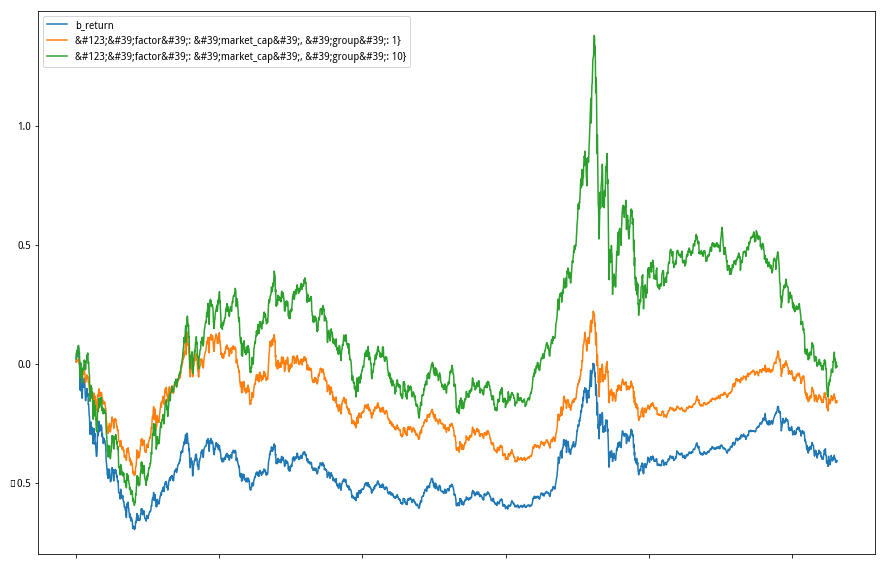

In [4]:
#先获取基准收益和交易日信息
gt = get_backtest(backtest_id = created_bt_ids[0])
res = gt.get_results()

b_return = []
t = []
for r in res:
    b_return.append(r['benchmark_returns'])
    t.append(r['time'])

#建立df存储数据   
factor_data_pd = pd.DataFrame(index = t)
factor_data_pd['b_return'] = b_return

#填入不同参数下的收益数据
for i in range(len(created_bt_ids)):
    gt = get_backtest(backtest_id = created_bt_ids[i])
    res = gt.get_results()
    name = gt.get_params()['name'] 
    s_return = []
    for r in res:
        s_return.append(r['returns'])

    factor_data_pd[name] = s_return

factor_data_pd.plot(figsize = (15,10))


In [ ]:
factor_data_pd.index = pd.to_datetime(factor_data_pd.index)
factor_data_pd.columns = ['bench_yield','yield_1st',"yield_2nd"]


In [ ]:

factor_data_pd['yield_1st_singleday'] = factor_data_pd['yield_1st'] - factor_data_pd['yield_1st'].shift(1)
factor_data_pd['yield_2nd_singleday'] = factor_data_pd['yield_2nd'] - factor_data_pd['yield_2nd'].shift(1)



In [ ]:
factor_data_pd = factor_data_pd.fillna(0)
factor_data_pd['month'] = np.array([d.strftime('%Y-%m') for d in factor_data_pd.index])


str(factor_data_pd.index.year) +'_'+ str(factor_data_pd.index.month)
factor_data_pd['yield_gap_singleday'] = np.log(1 + factor_data_pd['yield_1st_singleday'] - factor_data_pd['yield_2nd_singleday'])

factor_data_pd

In [ ]:
factor_load_series =  factor_data_pd.groupby('month')['yield_gap_singleday'].sum()


In [ ]:
factor_load_series = np.exp(factor_load_series) -1
factor_load_series

In [ ]:
np.mean(factor_load_series)

In [ ]:
np.std(factor_load_series)

# 合成代码，计算全量的因子载荷

In [18]:
# 明确代码
# 因子库
factor_pool = ['market_cap','turnover_ratio','inc_total_revenue_year_on_year','pe_ratio','pe_ratio_lyr','pb_ratio','pcf_ratio',
               'roe','roa','inc_return','net_profit_margin','gross_profit_margin',
               'operating_expense_to_total_revenue',
               'expense_to_total_revenue','operation_profit_to_total_revenue',
               'invesment_profit_to_profit',
               'adjusted_profit_to_profit','goods_sale_and_service_to_revenue','ocf_to_revenue',
               'ocf_to_operating_profit','inc_total_revenue_annual',
               'inc_revenue_year_on_year','inc_revenue_annual','inc_operation_profit_year_on_year',
               'inc_operation_profit_annual','inc_net_profit_year_on_year','inc_net_profit_annual',
               'inc_net_profit_to_shareholders_year_on_year','inc_net_profit_to_shareholders_annual'
              ]

# 存储结果的dict数组
result_factor_dict = {}

In [19]:
for factor_i in factor_pool[1:3]:
    # 1、初始化结果dict
    result_factor_dict[factor_i] = []
    
    # 2、设置初始因子值，进行回测
    
    print("1、开始进行测算，因子值为：%s"%str(factor_i))
    
    paramList=[[factor_i],[1,10]]
    paramNames=['factor','group']
    algorithmID='85a3023da4d41d18f99f6663fc205457'
    startDate='2008-01-01'
    endDate='2018-11-30'
    frequency='day'
    initialCash=100000
    maxBacktestNum=9 #最大同时回测数

    params=list(itertools.product(*paramList))

    df = pd.DataFrame(params,index=params,columns=paramNames)

    created_bt_ids = []


    for i in range(min(maxBacktestNum,df.shape[0])):
        var = df.iloc[i].to_dict()
        out_algorithm_id = create_backtest(algorithm_id=algorithmID, # id 需要自己拷贝
                            start_date=startDate, 
                            end_date=endDate, 
                            frequency=frequency, 
                            initial_cash=initialCash, 
                            initial_positions=None, 
                            extras= eval(str(var)),
                            name=str(var)
                            )
        created_bt_ids.append(out_algorithm_id)
        
        gt = get_backtest(out_algorithm_id)

        while 1:
            if gt.get_status() == 'done':
                break
            elif gt.get_status() == 'none':
                time.sleep(5)
            elif gt.get_status() == 'failed':
                break
            elif gt.get_status() == 'running':
                time.sleep(5)
            elif gt.get_status() == 'canceled':
                break
            elif gt.get_status() == 'paused':
                break
            elif gt.get_status() == 'deleted':
                break                

        
        # 生成
        created_bt_ids.append(out_algorithm_id)
    
    
    print("2、完成回测")
    
    # 3、获取回测情况，生成数据
    gt = get_backtest(backtest_id = created_bt_ids[0])
    res = gt.get_results()

    b_return = []
    t = []
    for r in res:
        b_return.append(r['benchmark_returns'])
        t.append(r['time'])

    #建立df存储数据   
    factor_data_pd = pd.DataFrame(index = t)
    factor_data_pd['b_return'] = b_return

    #填入不同参数下的收益数据
    for i in range(len(created_bt_ids)):
        gt = get_backtest(backtest_id = created_bt_ids[i])
        res = gt.get_results()
        name = gt.get_params()['name'] 
        s_return = []
        for r in res:
            s_return.append(r['returns'])

        factor_data_pd[name] = s_return

    # 4、根据数据生成pandas数组
    factor_data_pd.index = pd.to_datetime(factor_data_pd.index)
    factor_data_pd.columns = ['bench_yield','yield_1st',"yield_2nd"]

    factor_data_pd['yield_1st_singleday'] = factor_data_pd['yield_1st'] - factor_data_pd['yield_1st'].shift(1)
    factor_data_pd['yield_2nd_singleday'] = factor_data_pd['yield_2nd'] - factor_data_pd['yield_2nd'].shift(1)
   
    factor_data_pd = factor_data_pd.fillna(0)
    factor_data_pd['month'] = np.array([d.strftime('%Y-%m') for d in factor_data_pd.index])


    factor_data_pd['yield_gap_singleday'] = np.log(1 + factor_data_pd['yield_1st_singleday'] - factor_data_pd['yield_2nd_singleday'])

    factor_load_series =  factor_data_pd.groupby('month')['yield_gap_singleday'].sum()

    factor_load_series = np.exp(factor_load_series) -1
    print("3、生成数据")
    # 5、加入对应的dict中
    result_factor_dict[factor_i].append(np.mean(factor_load_series))
    result_factor_dict[factor_i].append(np.std(factor_load_series))


1、开始进行测算，因子值为：turnover_ratio
2、完成回测
3、生成数据
1、开始进行测算，因子值为：inc_total_revenue_year_on_year
2、完成回测
3、生成数据


In [20]:
result_factor_dict

{'turnover_ratio': [0.0011410019232449638, 0.026556412695353238],
 'inc_total_revenue_year_on_year': [-0.0018348381256666354,
  0.029012258781028546]}

In [21]:
result_factor_pd = pd.DataFrame.from_dict(result_factor_dict, orient='index')
result_factor_pd.to_csv('result__factor_pd.csv')

In [23]:
result_factor_pd

,0,1
turnover_ratio,0.001141,0.026556
inc_total_revenue_year_on_year,-0.001835,0.029012
